In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import *
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
import pprint
pp = pprint.PrettyPrinter(indent = 4)

# Load Dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
y_train.shape

(60000,)

In [ ]:
y_test.shape

(10000,)

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# visualizing the dataset

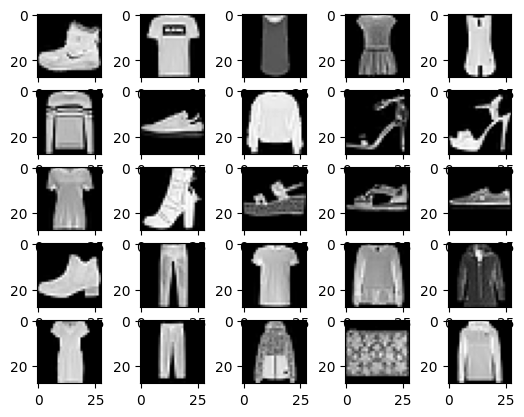

In [ ]:
for i in range(25):
    # define subplot
    plt.subplot(5, 5, i+1)
    # plot raw pixel data
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [ ]:
x_train =x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 7, 7, 32)         

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train,y_train, epochs=20, batch_size=512, shuffle=True, validation_split=0.1)

Epoch 1/20
106/106 [==============================] - 98s 913ms/step - loss: 0.8581 - accuracy: 0.6819 - val_loss: 0.4811 - val_accuracy: 0.8253
Epoch 2/20
106/106 [==============================] - 80s 754ms/step - loss: 0.5082 - accuracy: 0.8148 - val_loss: 0.4095 - val_accuracy: 0.8523
Epoch 3/20
106/106 [==============================] - 80s 757ms/step - loss: 0.4462 - accuracy: 0.8369 - val_loss: 0.3644 - val_accuracy: 0.8648
Epoch 4/20
106/106 [==============================] - 78s 730ms/step - loss: 0.4078 - accuracy: 0.8535 - val_loss: 0.3403 - val_accuracy: 0.8773
Epoch 5/20
106/106 [==============================] - 80s 750ms/step - loss: 0.3843 - accuracy: 0.8611 - val_loss: 0.3205 - val_accuracy: 0.8840
Epoch 6/20
106/106 [==============================] - 87s 805ms/step - loss: 0.3688 - accuracy: 0.8662 - val_loss: 0.3102 - val_accuracy: 0.8850
Epoch 7/20
106/106 [==============================] - 78s 741ms/step - loss: 0.3559 - accuracy: 0.8700 - val_loss: 0.3083 - val_ac

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test,y_test)

313/313 [==============================] - 4s 13ms/step - loss: 0.2588 - accuracy: 0.9049


In [ ]:
print(test_accuracy)

0.9049000144004822


In [ ]:
!pip install -q -U keras-tuner

In [ ]:
import keras_tuner as kt

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(x_train,y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 416 and the optimal learning rate for the optimizer
is 0.001.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
1500/1500 [==============================] - 16s 10ms/step - loss: 0.4920 - accuracy: 0.8253 - val_loss: 0.3965 - val_accuracy: 0.8551
Epoch 2/50
1500/1500 [==============================] - 11s 7ms/step - loss: 0.3696 - accuracy: 0.8647 - val_loss: 0.3610 - val_accuracy: 0.8688
Epoch 3/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3309 - accuracy: 0.8791 - val_loss: 0.3557 - val_accuracy: 0.8675
Epoch 4/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3052 - accuracy: 0.8874 - val_loss: 0.3165 - val_accuracy: 0.8853
Epoch 5/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2862 - accuracy: 0.8942 - val_loss: 0.3247 - val_accuracy: 0.8865
Epoch 6/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2715 - accuracy: 0.8990 - val_loss: 0.3251 - val_accuracy: 0.8850
Epoch 7/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2583 - accuracy: 0.9042 - val_loss: 0.3102 - val_accura

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/35
1500/1500 [==============================] - 8s 5ms/step - loss: 0.4945 - accuracy: 0.8248 - val_loss: 0.4163 - val_accuracy: 0.8466
Epoch 2/35
1500/1500 [==============================] - 8s 6ms/step - loss: 0.3733 - accuracy: 0.8636 - val_loss: 0.3793 - val_accuracy: 0.8620
Epoch 3/35
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3316 - accuracy: 0.8789 - val_loss: 0.3416 - val_accuracy: 0.8768
Epoch 4/35
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3073 - accuracy: 0.8858 - val_loss: 0.3399 - val_accuracy: 0.8770
Epoch 5/35
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2890 - accuracy: 0.8924 - val_loss: 0.3509 - val_accuracy: 0.8741
Epoch 6/35
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2724 - accuracy: 0.8983 - val_loss: 0.3201 - val_accuracy: 0.8830
Epoch 7/35
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2582 - accuracy: 0.9046 - val_loss: 0.3339 - val_accuracy:

In [ ]:
eval_result = hypermodel.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 2ms/step - loss: 0.4707 - accuracy: 0.8882
[test loss, test accuracy]: [0.4706501066684723, 0.8881999850273132]


In [ ]:
#Model Prediction

predict_x=model.predict(x_test)
y_pred=np.argmax(predict_x,axis=1)

313/313 [==============================] - 1s 2ms/step


In [ ]:
for i in range(0,10):
    print(y_pred[i], y_test[i]) #predicted and actual class

9 9
2 2
1 1
1 1
6 6
1 1
4 4
6 6
5 5
7 7


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cn = confusion_matrix(y_test, y_pred)
print(cn)

[[846   2  12  17   6   1 107   0   9   0]
 [  3 973   2  13   5   0   4   0   0   0]
 [ 17   1 726   7 132   1 111   0   5   0]
 [ 21   6   8 877  54   0  28   0   6   0]
 [  0   0  47  16 876   0  59   0   2   0]
 [  0   0   0   1   0 955   0  27   2  15]
 [109   0  46  34  74   0 729   0   8   0]
 [  0   0   0   0   0   9   0 976   1  14]
 [  6   0   4   5   2   5   5   3 970   0]
 [  0   0   0   0   0   8   1  42   0 949]]


In [ ]:
acc_cm = accuracy_score(y_test, y_pred)
print(acc_cm)

0.8877


In [ ]:
from sklearn.metrics  import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.86      0.73      0.79      1000
           3       0.90      0.88      0.89      1000
           4       0.76      0.88      0.82      1000
           5       0.98      0.95      0.97      1000
           6       0.70      0.73      0.71      1000
           7       0.93      0.98      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

